**1. 시스템 환경**
- OS: Window 11 pro
- CPU: Intel Core Ultra 9 285K  
- RAM: 64GB  
- GPU: NVIDIA GeForce RTX 4090  

**2. 라이브러리 버전**
- pandas: 2.2.3  
- numpy: 1.26.4  
- matplotlib: 3.9.2  
- scikit-learn: 1.6.1  
- lightgbm: 4.6.0  
- catboost: 1.2.7  
- xgboost: 3.0.0

In [7]:
import pandas as pd
import numpy as np
import warnings
import gc
import math

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.utils.class_weight import compute_class_weight

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

#### Data Load

In [8]:
# 데이터 분할(폴더) 구분
data_splits = ["train", "test"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "회원정보": {"folder": "1.회원정보", "suffix": "회원정보", "var_prefix": "customer"},
    "신용정보": {"folder": "2.신용정보", "suffix": "신용정보", "var_prefix": "credit"},
    "승인매출정보": {"folder": "3.승인매출정보", "suffix": "승인매출정보", "var_prefix": "sales"},
    "청구정보": {"folder": "4.청구입금정보", "suffix": "청구정보", "var_prefix": "billing"},
    "잔액정보": {"folder": "5.잔액정보", "suffix": "잔액정보", "var_prefix": "balance"},
    "채널정보": {"folder": "6.채널정보", "suffix": "채널정보", "var_prefix": "channel"},
    "마케팅정보": {"folder": "7.마케팅정보", "suffix": "마케팅정보", "var_prefix": "marketing"},
    "성과정보": {"folder": "8.성과정보", "suffix": "성과정보", "var_prefix": "performance"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07', '08', '09', '10', '11', '12']

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]
        
        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"./data/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

customer_train_07 is loaded from ./data/train/1.회원정보/201807_train_회원정보.parquet
customer_train_08 is loaded from ./data/train/1.회원정보/201808_train_회원정보.parquet
customer_train_09 is loaded from ./data/train/1.회원정보/201809_train_회원정보.parquet
customer_train_10 is loaded from ./data/train/1.회원정보/201810_train_회원정보.parquet
customer_train_11 is loaded from ./data/train/1.회원정보/201811_train_회원정보.parquet
customer_train_12 is loaded from ./data/train/1.회원정보/201812_train_회원정보.parquet
credit_train_07 is loaded from ./data/train/2.신용정보/201807_train_신용정보.parquet
credit_train_08 is loaded from ./data/train/2.신용정보/201808_train_신용정보.parquet
credit_train_09 is loaded from ./data/train/2.신용정보/201809_train_신용정보.parquet
credit_train_10 is loaded from ./data/train/2.신용정보/201810_train_신용정보.parquet
credit_train_11 is loaded from ./data/train/2.신용정보/201811_train_신용정보.parquet
credit_train_12 is loaded from ./data/train/2.신용정보/201812_train_신용정보.parquet
sales_train_07 is loaded from ./data/train/3.승인매출정보/201807_train

729

#### Data Preprocessing(1) : Concat & Merge

In [9]:
# 데이터 유형별 설정 
info_categories = ["customer", "credit", "sales", "billing", "balance", "channel", "marketing", "performance"]

# 월 설정
months = ['07', '08', '09', '10', '11', '12']

In [10]:
#### Train ####

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train_{month}"] for month in months]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")


customer_train_df = train_dfs["customer_train_df"]
credit_train_df   = train_dfs["credit_train_df"]
sales_train_df    = train_dfs["sales_train_df"]
billing_train_df  = train_dfs["billing_train_df"]
balance_train_df  = train_dfs["balance_train_df"]
channel_train_df  = train_dfs["channel_train_df"]
marketing_train_df= train_dfs["marketing_train_df"]
performance_train_df = train_dfs["performance_train_df"]

gc.collect()

customer_train_df is created with shape: (2400000, 78)
credit_train_df is created with shape: (2400000, 42)
sales_train_df is created with shape: (2400000, 406)
billing_train_df is created with shape: (2400000, 46)
balance_train_df is created with shape: (2400000, 82)
channel_train_df is created with shape: (2400000, 105)
marketing_train_df is created with shape: (2400000, 64)
performance_train_df is created with shape: (2400000, 49)


0

In [11]:
#### Test ####

# test 데이터에 대해 train과 동일한 방법 적용
test_dfs = {}

for prefix in info_categories:
    df_list = [globals()[f"{prefix}_test_{month}"] for month in months]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")


customer_test_df = test_dfs["customer_test_df"]
credit_test_df   = test_dfs["credit_test_df"]
sales_test_df    = test_dfs["sales_test_df"]
billing_test_df  = test_dfs["billing_test_df"]
balance_test_df  = test_dfs["balance_test_df"]
channel_test_df  = test_dfs["channel_test_df"]
marketing_test_df= test_dfs["marketing_test_df"]
performance_test_df = test_dfs["performance_test_df"]

gc.collect()

customer_test_df is created with shape: (600000, 77)
credit_test_df is created with shape: (600000, 42)
sales_test_df is created with shape: (600000, 406)
billing_test_df is created with shape: (600000, 46)
balance_test_df is created with shape: (600000, 82)
channel_test_df is created with shape: (600000, 105)
marketing_test_df is created with shape: (600000, 64)
performance_test_df is created with shape: (600000, 49)


0

In [12]:
#### Train ####

train_df = customer_train_df.merge(credit_train_df, on=['기준년월', 'ID'], how='left')
print("Step1 저장 완료: train_step1, shape:", train_df.shape)
del customer_train_df, credit_train_df
gc.collect()

# 이후 merge할 데이터프레임 이름과 단계 정보를 리스트에 저장
merge_list = [
    ("sales_train_df",    "Step2"),
    ("billing_train_df",  "Step3"),
    ("balance_train_df",  "Step4"),
    ("channel_train_df",  "Step5"),
    ("marketing_train_df","Step6"),
    ("performance_train_df", "최종")
]

# 나머지 단계 merge
for df_name, step in merge_list:
    # globals()로 동적 변수 접근하여 merge 수행
    train_df = train_df.merge(globals()[df_name], on=['기준년월', 'ID'], how='left')
    print(f"{step} 저장 완료: train_{step}, shape:", train_df.shape)
    # 사용한 변수는 메모리 해제를 위해 삭제
    del globals()[df_name]
    gc.collect()

Step1 저장 완료: train_step1, shape: (2400000, 118)
Step2 저장 완료: train_Step2, shape: (2400000, 522)
Step3 저장 완료: train_Step3, shape: (2400000, 566)
Step4 저장 완료: train_Step4, shape: (2400000, 646)
Step5 저장 완료: train_Step5, shape: (2400000, 749)
Step6 저장 완료: train_Step6, shape: (2400000, 811)
최종 저장 완료: train_최종, shape: (2400000, 858)


In [13]:
#### Test ####

test_df = customer_test_df.merge(credit_test_df, on=['기준년월', 'ID'], how='left')
print("Step1 저장 완료: test_step1, shape:", test_df.shape)
del customer_test_df, credit_test_df
gc.collect()

# 이후 merge할 데이터프레임 이름과 단계 정보를 리스트에 저장
merge_list = [
    ("sales_test_df",    "Step2"),
    ("billing_test_df",  "Step3"),
    ("balance_test_df",  "Step4"),
    ("channel_test_df",  "Step5"),
    ("marketing_test_df","Step6"),
    ("performance_test_df", "최종")
]

# 나머지 단계 merge
for df_name, step in merge_list:
    # globals()로 동적 변수 접근하여 merge 수행
    test_df = test_df.merge(globals()[df_name], on=['기준년월', 'ID'], how='left')
    print(f"{step} 저장 완료: test_{step}, shape:", test_df.shape)
    # 사용한 변수는 메모리 해제를 위해 삭제
    del globals()[df_name]
    gc.collect()

Step1 저장 완료: test_step1, shape: (600000, 117)
Step2 저장 완료: test_Step2, shape: (600000, 521)
Step3 저장 완료: test_Step3, shape: (600000, 565)
Step4 저장 완료: test_Step4, shape: (600000, 645)
Step5 저장 완료: test_Step5, shape: (600000, 748)
Step6 저장 완료: test_Step6, shape: (600000, 810)
최종 저장 완료: test_최종, shape: (600000, 857)


#### Save merged data

In [14]:
train_df.to_parquet('./data/train/train.parquet', index=False)
test_df.to_parquet('./data/test/test.parquet', index=False)

### 1. merged 데이터셋 불러오기

In [15]:
train_df = pd.read_parquet('./data/train/train.parquet')
test_df = pd.read_parquet('./data/test/test.parquet')

print('shape of original train set in member: ', train_df.shape)
print('shape of original test set in member: ', test_df.shape)

shape of original train set in member:  (2400000, 858)
shape of original test set in member:  (600000, 857)


### 2. 단일 값 가지는 컬럼 제거

In [16]:
# Train(단일 값 가지는 columns 추출)
constant_columns_train = train_df.nunique() == 1
constant_columns_train = constant_columns_train[constant_columns_train].index.tolist()
print(constant_columns_train)
print(len(constant_columns_train))

train_filtered = train_df.drop(columns=constant_columns_train)
test_filtered = test_df.drop(columns=constant_columns_train)

print('shape of filtered train set in member: ', train_filtered.shape)
print('shape of filtered test set in member: ', test_filtered.shape)

['이용카드수_체크_가족', '이용금액_R3M_체크_가족', '연회비할인카드수_B0M', '할인금액_기본연회비_B0M', '할인금액_제휴연회비_B0M', '상품관련면제카드수_B0M', '임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M', '시장연체상환여부_R3M', '이용건수_부분무이자_B0M', '이용금액_부분무이자_B0M', '여유_여행이용금액', '납부_렌탈료이용금액', '납부_유선방송이용금액', '납부_건강연금이용금액', '할부건수_부분_3M_R12M', '할부건수_부분_6M_R12M', '할부건수_부분_14M_R12M', '할부금액_부분_3M_R12M', 'RP건수_유선방송_B0M', 'RP건수_건강_B0M', 'RP후경과월_유선방송', 'RP후경과월_건강', '증감_RP건수_유선방송_전월', '증감_RP건수_건강_전월', '이용개월수_당사페이_R6M', '이용금액_당사페이_R6M', '이용금액_당사기타_R6M', '이용건수_당사페이_R6M', '이용건수_당사기타_R6M', '이용금액_당사페이_R3M', '이용금액_당사기타_R3M', '이용건수_당사페이_R3M', '이용건수_당사기타_R3M', '이용금액_당사페이_B0M', '이용금액_당사기타_B0M', '이용건수_당사페이_B0M', '이용건수_당사기타_B0M', '승인거절건수_입력오류_B0M', '승인거절건수_기타_B0M', '대표결제방법코드', '카드론잔액_최종경과월', '최종연체개월수_R15M', 'RV잔액이월횟수_R6M', 'RV잔액이월횟수_R3M', '연체잔액_일시불_해외_B0M', '연체잔액_RV일시불_해외_B0M', '연체잔액_할부_해외_B0M', '연체잔액_CA_해외_B0M', '인입횟수_금융_IB_R6M', '인입불만횟수_IB_R6M', '인입불만일수_IB_R6M', '인입불만월수_IB_R6M', '인입불만후경과월_IB_R6M', '인입불만횟수_IB_B0M', '인입불만일수_IB_B0M', 'IB문의건수_한도_B0M', 'IB문의건수_결제_B0M', 'I

### 3. 데이터셋 저장

In [17]:
train_filtered.to_parquet('./data/train/train_filtered.parquet', index=False)
test_filtered.to_parquet('./data/test/test_filtered.parquet', index=False)

### 4. filtered 데이터셋 불러오기

In [18]:
def trainform_columns_type(df):
    """
    dataframe의 각 column들을 최적화된 데이터 타입으로 변환하여 메모리 사용량을 줄이는 함수.
    - float64 -> float32
    - int64 -> int32
    """
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'float64':
            df[col] = df[col].astype('float32')  
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')  
    return df

In [19]:
train_df = pd.read_parquet('./data/train/train_filtered.parquet')
test_df = pd.read_parquet('./data/test/test_filtered.parquet')

# reduce memory by chaing data types of columns
train_df = trainform_columns_type(train_df)
test_df = trainform_columns_type(test_df)

print('shape of original train set in member: ', train_df.shape)
print('shape of original test set in member: ', test_df.shape)

shape of original train set in member:  (2400000, 750)
shape of original test set in member:  (600000, 749)


#### 5. Null 값(missing value)을 가지는 column은 제거

In [20]:
# remove columns to have null values
null_cols = train_df.columns[train_df.isnull().any()] 
train_df = train_df.drop(columns=null_cols)  # training set에서 null 값 가지는 열 제거
test_df = test_df.drop(columns=null_cols, errors='ignore') # test set에 적용.

print('shape of train dataset(drop colums to have null values)', train_df.shape) 
print('shape of test dataset(drop colums to have null values)', test_df.shape)

shape of train dataset(drop colums to have null values) (2400000, 719)
shape of test dataset(drop colums to have null values) (600000, 718)


#### 6. 불균형 분포를 가진 변수들 제거

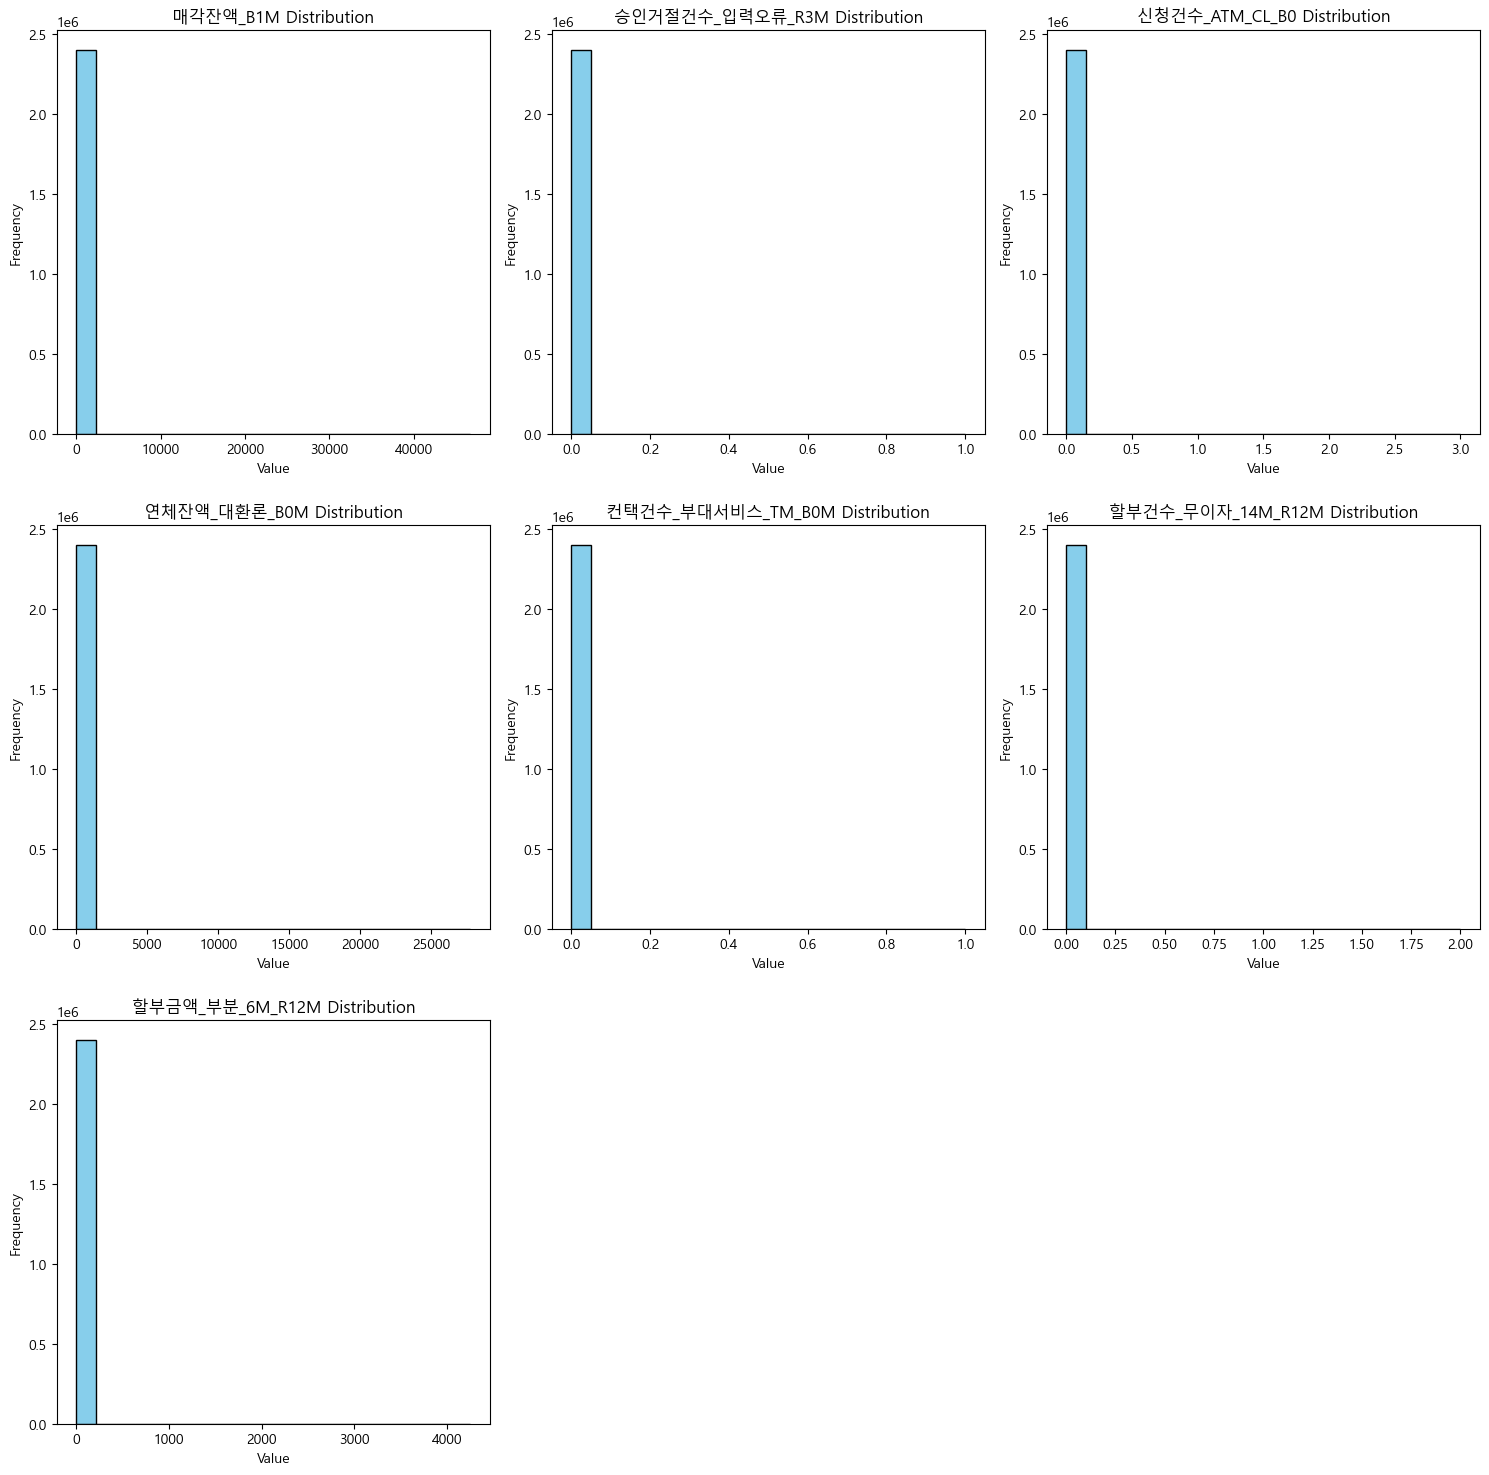

In [21]:
columns = ['매각잔액_B1M', 
            '승인거절건수_입력오류_R3M', 
            '신청건수_ATM_CL_B0', 
            '연체잔액_대환론_B0M', 
            '컨택건수_부대서비스_TM_B0M', 
            '할부건수_무이자_14M_R12M', 
            '할부금액_부분_6M_R12M']

fig, axes = plt.subplots(3, 3, figsize=(15, 15)) 
axes = axes.flatten()

for i, column in enumerate(columns):
    axes[i].hist(train_df[column].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{column} Distribution')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [22]:
print(train_df['매각잔액_B1M'].value_counts())
print("\n") 
print(train_df['승인거절건수_입력오류_R3M'].value_counts())
print("\n") 
print(train_df['신청건수_ATM_CL_B0'].value_counts())
print("\n") 
print(train_df['연체잔액_대환론_B0M'].value_counts())
print("\n")
print(train_df['컨택건수_부대서비스_TM_B0M'].value_counts())
print("\n") 
print(train_df['할부건수_무이자_14M_R12M'].value_counts())
print("\n")  
print(train_df['할부금액_부분_6M_R12M'].value_counts())

매각잔액_B1M
0        2399999
46708          1
Name: count, dtype: int64


승인거절건수_입력오류_R3M
0    2399990
1         10
Name: count, dtype: int64


신청건수_ATM_CL_B0
0    2399999
3          1
Name: count, dtype: int64


연체잔액_대환론_B0M
0        2399994
27479          1
27348          1
27752          1
27018          1
27108          1
27663          1
Name: count, dtype: int64


컨택건수_부대서비스_TM_B0M
0    2399999
1          1
Name: count, dtype: int64


할부건수_무이자_14M_R12M
0    2399997
2          3
Name: count, dtype: int64


할부금액_부분_6M_R12M
0       2399999
4249          1
Name: count, dtype: int64


In [23]:
train_df = train_df.drop(columns=columns)
test_df = test_df.drop(columns=columns)

print('shape of train dataset(drop colums)', train_df.shape) 
print('shape of test dataset(drop colums)', test_df.shape)

shape of train dataset(drop colums) (2400000, 712)
shape of test dataset(drop colums) (600000, 711)


#### 7. 범주형 변수 Label encdoing

In [24]:
feature_cols = [col for col in train_df.columns if col not in ['ID', 'Segment']]
X= train_df[feature_cols].copy()
y = train_df['Segment'].copy()

# 라벨 인코딩
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

X_test = test_df[feature_cols].copy()
groups = train_df['ID'].values  # 그룹화용

# 필요 시 범주형 변수 라벨인코딩
cat_cols = X.select_dtypes(include=['object']).columns
for c in cat_cols:
    le_c = LabelEncoder()
    X[c] = le_c.fit_transform(X[c])
    if c in X_test.columns:
        unseen = set(X_test[c]) - set(le_c.classes_)
        if unseen:
            le_c.classes_ = np.append(le_c.classes_, list(unseen))
        X_test[c] = le_c.transform(X_test[c])

del train_df
gc.collect()

0

#### 8. Target Class 불균형으로 인한 각 Target class(A, B, C, D, E)마다 가중치 설정
##### * 불균형 데이터셋에서 소수 클래스는 더 높은 가중치를 부여하는 반면, 다수 클래스는 낮은 가중치를 부여함.

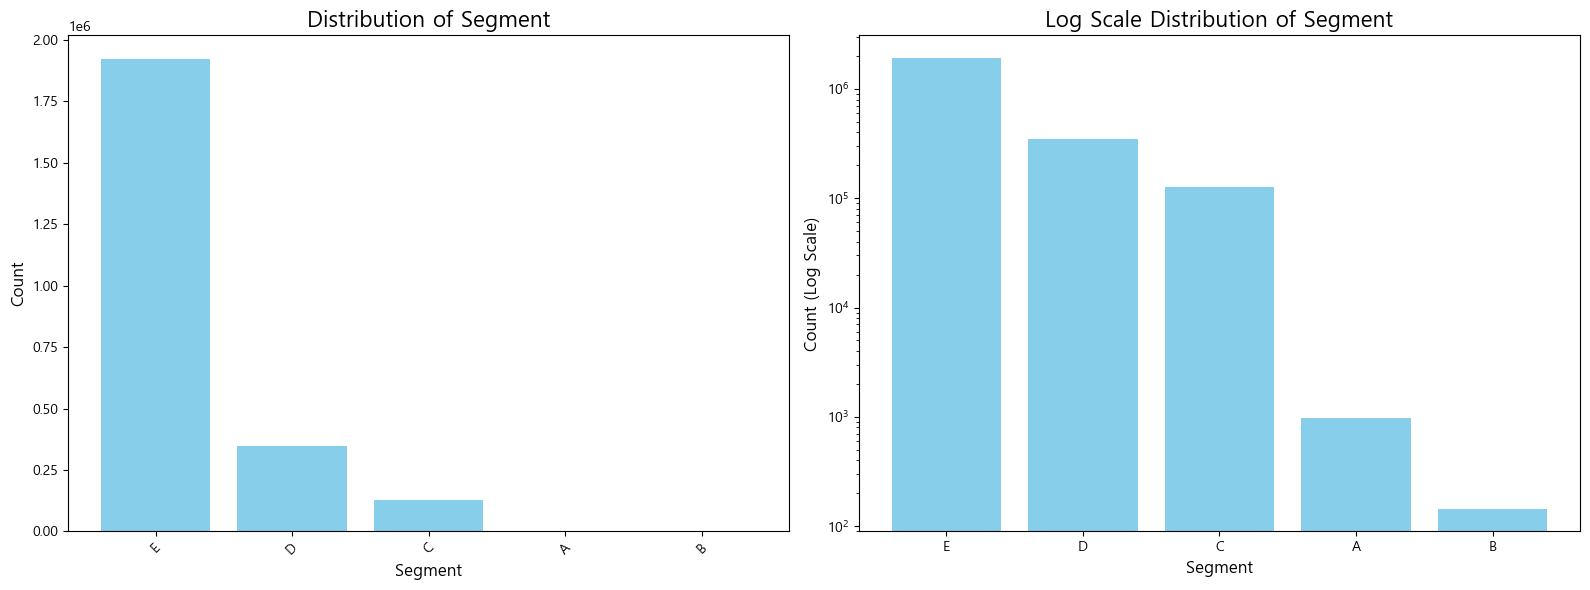

In [25]:
# 'Segment' class 분포
segment_counts = y.value_counts()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(segment_counts.index, segment_counts.values, color='skyblue')
axes[0].set_title('Distribution of Segment', fontsize=16)
axes[0].set_xlabel('Segment', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(segment_counts.index, segment_counts.values, color='skyblue')
axes[1].set_yscale('log')
axes[1].set_title('Log Scale Distribution of Segment', fontsize=16)
axes[1].set_xlabel('Segment', fontsize=12)
axes[1].set_ylabel('Count (Log Scale)', fontsize=12)

plt.tight_layout()
plt.show()

In [26]:
# **compute_class_weight**는 클래스별 가중치를 계산하는 함수.
# class_weight='balanced'는 각 클래스의 가중치를 데이터셋에서의 불균형 정도에 따라 자동으로 조정.

classes = np.unique(y_encoded)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
class_weight_dict = dict(zip(classes, weights))
sample_weights = np.array([class_weight_dict[y] for y in y_encoded])
print(class_weight_dict)
print(sample_weights)

{0: 493.82716049382714, 1: 3333.3333333333335, 2: 3.7620503174229953, 3: 1.3744051402752246, 4: 0.2497330977517778}
[1.37440514 0.2497331  3.76205032 ... 3.76205032 0.2497331  0.2497331 ]


### 9. Base Model Hyperparameters 초기화

In [27]:
catboost_params = {
    'iterations': 10000,
    'depth': 8,
    'learning_rate': 0.2187791131429615,
    'l2_leaf_reg': 0.0888872986795632,
    'bootstrap_type': 'Bernoulli',
    'grow_policy': 'Lossguide',
    'min_data_in_leaf': 111,
    'task_type': 'GPU',
    'random_seed': 42,
    'verbose': 0
}

lgbm_params = {
    'device': 'gpu',

    'random_state': 42
    }

xgb_params = {
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'max_depth': 8,
    'learning_rate': 0.2187791131429615,
    'reg_lambda': 0.0888872986795632,
    'reg_alpha': 0.0888872986795632,
    'min_child_weight': 111,
    'subsample': 0.8,                
    'colsample_bytree': 1.0,
    'grow_policy': 'lossguide',
    'n_estimators': 10000,
    'random_state': 42,
    'verbosity': 0
}

### 10. 회원 id별 Group 5 Fold cross validation

In [28]:
n_folds = 5
n_class = len(np.unique(y_encoded))
sgkf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=42)

# models
xgb_clf = XGBClassifier(**xgb_params)
cat_clf = CatBoostClassifier(**catboost_params)
lgbm_clf = LGBMClassifier(**lgbm_params)

models = [xgb_clf, cat_clf, lgbm_clf]



for model in models:
    print(model.__class__.__name__, 'model start...')
    
    accuracy_scores = []
    recall_scores = []
    precision_scores = []
    fi_scores = []
    classification_reports = []
    
    # 회원 id별 group fold
    for fold_idx, (train_index, valid_index) in enumerate(sgkf.split(X, y_encoded, groups)):
        print(f'Fold {fold_idx + 1}-th {model.__class__.__name__} model training...')
        
        X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_val= y_encoded[train_index], y_encoded[valid_index]
        
        
        sample_weights_fold = sample_weights[train_index]
        model.fit(X_tr, y_tr, sample_weight=sample_weights_fold)
        
        
        y_val_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred, average='macro')
        precision = precision_score(y_val, y_val_pred, average='macro')
        f1 = f1_score(y_val, y_val_pred, average='macro')
        report = classification_report(y_val, y_val_pred)
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        
        print(f"Fold {fold_idx + 1} Accuracy: {accuracy:.4f}")
        print(f"Fold {fold_idx + 1} Recall: {recall:.4f}")
        print(f"Fold {fold_idx + 1} Precision: {precision:.4f}")
        print(f"Fold {fold_idx + 1} F1-score: {f1:.4f}")
        print(f"Fold {fold_idx + 1} Classification Report\n:{report}")
        print(f"Fold {fold_idx + 1} Confusion Matrix:\n{conf_matrix}")
        print('-'*40)
        
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        precision_scores.append(precision)
        fi_scores.append(f1)
        
    print(f"K-Fold mean Accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"K-Fold mean Recall: {np.mean(recall_scores):.4f}")
    print(f"K-Fold mean Precision: {np.mean(precision_scores):.4f}")
    print(f"K-Fold mean F1-score: {np.mean(fi_scores):.4f}")

XGBClassifier model start...
Fold 1-th XGBClassifier model training...
Fold 1 Accuracy: 0.9403
Fold 1 Recall: 0.5771
Fold 1 Precision: 0.6121
Fold 1 F1-score: 0.5777
Fold 1 Classification Report
:              precision    recall  f1-score   support

           0       0.24      0.28      0.26       138
           1       0.25      0.03      0.06        30
           2       0.79      0.77      0.78     24876
           3       0.80      0.83      0.81     69792
           4       0.98      0.97      0.97    385170

    accuracy                           0.94    480006
   macro avg       0.61      0.58      0.58    480006
weighted avg       0.94      0.94      0.94    480006

Fold 1 Confusion Matrix:
[[    39      0     97      1      1]
 [     3      1     25      1      0]
 [    89      3  19209   4856    719]
 [    16      0   3747  57579   8450]
 [    14      0   1188   9465 374503]]
----------------------------------------
Fold 2-th XGBClassifier model training...
Fold 2 Accuracy:

  File "c:\Users\yoons\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\yoons\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yoons\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\yoons\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 82089
[LightGBM] [Info] Number of data points in the train set: 1919994, number of used features: 703
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 168 dense feature groups (307.62 MB) transferred to GPU in 0.108574 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.552947
[LightGBM] [Info] Start training from score -1.633440
[LightGBM] [Info] Start training from score -1.616698
[LightGBM] [Info] Start training from score -1.622766
[LightGBM] [Info] Start training from score -1.623462
Fold 1 Accuracy: 0.8692
Fold 1 Recall: 0.5917
Fold 1 Precision: 0.4593
Fold 1 F1-score: 0.5033
Fold 1 Classification Report
:              precision    recall  f1-score   support

           0    

### 11. Soft Voting ensemble

In [29]:
test_probabilities = np.zeros((len(X_test), n_class))

for model in models:
    test_probabilities += model.predict_proba(X_test)
    
# Soft Voting ensemble
test_probabilities /= len(models)
test_predictions = np.argmax(test_probabilities, axis=1)
y_test_pred_labels = le_target.inverse_transform(test_predictions)
test_data = test_df.copy()
test_data["pred_label"] = y_test_pred_labels

submission = (
    test_data.groupby("ID")["pred_label"]
    .agg(lambda x: x.value_counts().idxmax())  # ID별 다수결
    .reset_index()
)
submission.columns = ["ID", "Segment"]

In [ ]:
# 결과 저장
submission.to_csv("./results/final_submission.csv", index=False)